In [2]:
# load dataset from zwhe99/DeepMath-103K

import datasets

dataset = datasets.load_dataset("zwhe99/DeepMath-103K")

print(dataset)

/home/zzhan483/miniconda3/envs/lvm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zzhan483/miniconda3/envs/lvm/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


DatasetDict({
    train: Dataset({
        features: ['question', 'final_answer', 'difficulty', 'topic', 'r1_solution_1', 'r1_solution_2', 'r1_solution_3'],
        num_rows: 103022
    })
})


In [3]:
# random sample 10000 data from dataset
sampled_dataset = dataset['train'].shuffle(seed=42).select(range(10000))

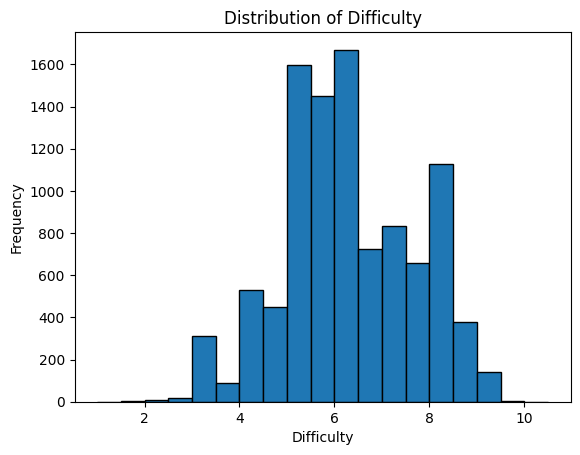

In [4]:
# distribution of difficulty
import matplotlib.pyplot as plt
difficulty_distribution = list(sampled_dataset['difficulty'])

plt.hist(difficulty_distribution, bins=[i * 0.5 for i in range(int(min(difficulty_distribution) * 2), int(max(difficulty_distribution) * 2) + 2)], edgecolor='black')
plt.title('Distribution of Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Frequency')
plt.show()

In [5]:
#　'question', 'final_answer', 'difficulty', 'topic', 'r1_solution_1', 'r1_solution_2', 'r1_solution_3'
MATH_QUERY_TEMPLATE = """
Please reason step by step, and put your final answer within \\boxed{{}}.

{Question}
""".strip()
messages = []
for i in range(len(sampled_dataset)):
    # print(sampled_dataset[i]['question'])
    # print(sampled_dataset[i]['final_answer'])
    # print(sampled_dataset[i]['difficulty'])
    # print(sampled_dataset[i]['topic'])
    message = [{"role": "user", "content": MATH_QUERY_TEMPLATE.format(Question=sampled_dataset[i]["question"])}]
    messages.append(message)

In [ ]:
import openai

client = openai.Client(base_url=f"http://127.0.0.1:10001/v1", api_key="None")

data = []
for i in range(len(sampled_dataset)):
    message = [{"role": "user", "content": MATH_QUERY_TEMPLATE.format(Question=sampled_dataset[i]["question"])}]

    response = client.chat.completions.create(
        model="Qwen/Qwen3-4B-Instruct-2507",
        messages=message,

        temperature=0.6,
        max_tokens=5000,
        top_p=0.9,
    )
    answer = response.choices[0].message.content
    single_data = {
        "conversations": [
            {
                "from": "human",
                "value": MATH_QUERY_TEMPLATE.format(Question=sampled_dataset[i]["question"])
            },
            {
                "from": "gpt",
                "value": answer
            },
        ],
        "difficulty": sampled_dataset[i]["difficulty"],
    }
    data.append(single_data)

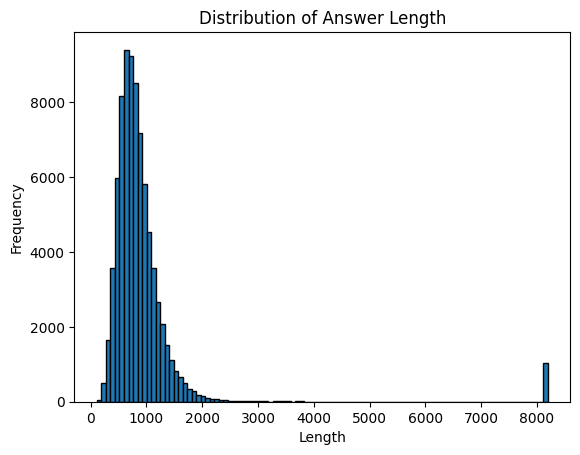

In [1]:
import json
import matplotlib.pyplot as plt
with open("/data1/zhenzhang/dir1/LLaMA-Factory-Lenght-Value-Model/data/deepmath_10000_3b.json", "r") as f:
    data = json.load(f)
length_data = [d["meta_info"]["answer_token_length"] for d in data]
plt.hist(length_data, bins=100, edgecolor='black')
plt.title('Distribution of Answer Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()


Gamma distribution parameters: shape=6.969, scale=112.632
K-S test: statistic=0.0222, p-value=0.0000


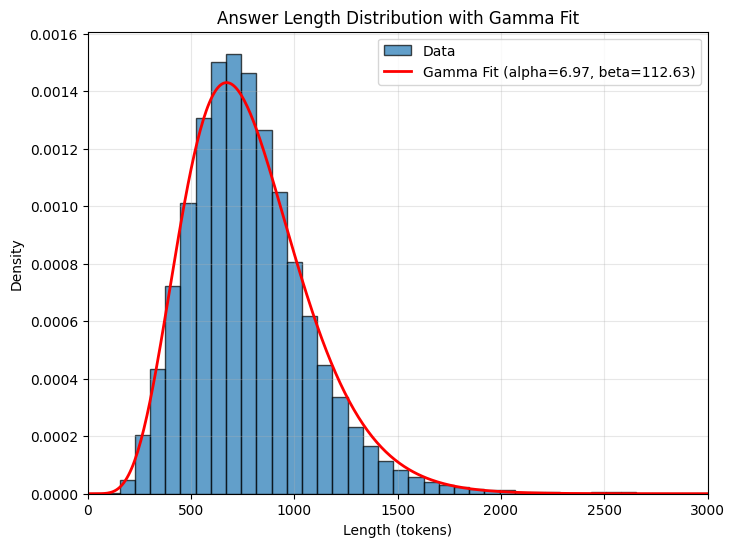

Data statistics (<= 8000 tokens):
  Sample size: 447993
  Mean: 784.94
  Standard deviation: 316.76
  Median: 744.00
Gamma distribution theoretical mean: 784.94
Gamma distribution theoretical std: 297.34


In [11]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

# Load data
with open("/data2/zzhang/dir1/LLaMA-Factory-Lenght-Value-Model/data/dapo_math_17k_7000.json", "r") as f:
    data = json.load(f)
length_data = [d["meta_info"]["answer_token_length"] for d in data]

# Filter: ignore values > 8000
filtered_length_data = [x for x in length_data if x <= 8000]

# Create histogram
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(filtered_length_data, bins=100, density=True, alpha=0.7, edgecolor='black', label='Data')

# Fit Gamma distribution using scipy.stats
shape, loc, scale = stats.gamma.fit(filtered_length_data, floc=0)  # floc=0 fixes location parameter to 0
print(f"Gamma distribution parameters: shape={shape:.3f}, scale={scale:.3f}")

# Generate x values for fitted curve
x = np.linspace(min(filtered_length_data), max(filtered_length_data), 1000)
# Calculate Gamma distribution probability density function
gamma_pdf = stats.gamma.pdf(x, shape, loc=loc, scale=scale)

# Plot fitted curve
plt.plot(x, gamma_pdf, 'r-', linewidth=2, label=f'Gamma Fit (alpha={shape:.2f}, beta={scale:.2f})')

# Calculate goodness of fit (Kolmogorov-Smirnov test)
ks_statistic, p_value = stats.kstest(filtered_length_data, lambda x: stats.gamma.cdf(x, shape, loc=loc, scale=scale))
print(f"K-S test: statistic={ks_statistic:.4f}, p-value={p_value:.4f}")

plt.title('Answer Length Distribution with Gamma Fit')
plt.xlabel('Length (tokens)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 3000)
plt.grid(True, alpha=0.3)
plt.show()

# Display basic statistics
print(f"Data statistics (<= 8000 tokens):")
print(f"  Sample size: {len(filtered_length_data)}")
print(f"  Mean: {np.mean(filtered_length_data):.2f}")
print(f"  Standard deviation: {np.std(filtered_length_data):.2f}")
print(f"  Median: {np.median(filtered_length_data):.2f}")
print(f"Gamma distribution theoretical mean: {shape * scale:.2f}")
print(f"Gamma distribution theoretical std: {np.sqrt(shape * scale**2):.2f}")

Truncated Gamma (loc=0) fit for X<=8000
  shape=6.9691, scale=112.6317
  KS: statistic=0.0222, p-value=0.0000
  CvM: statistic=68.3980, p-value=0.0000
  Moments (theoretical, truncated):
    mean=784.94, std=297.34
  Moments (empirical):
    mean=784.94, std=316.76


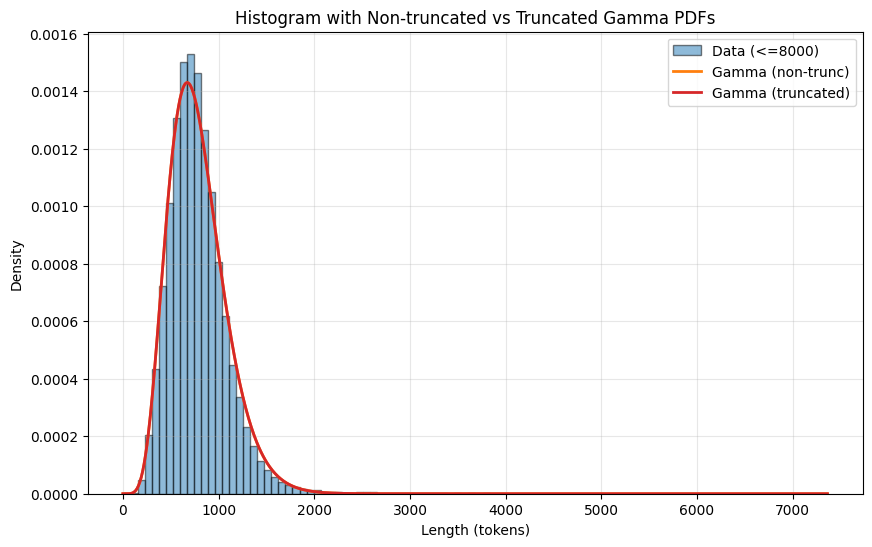

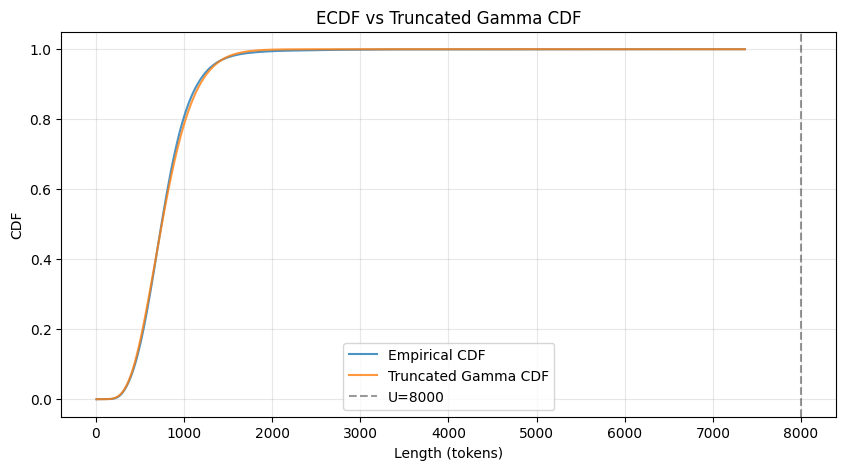

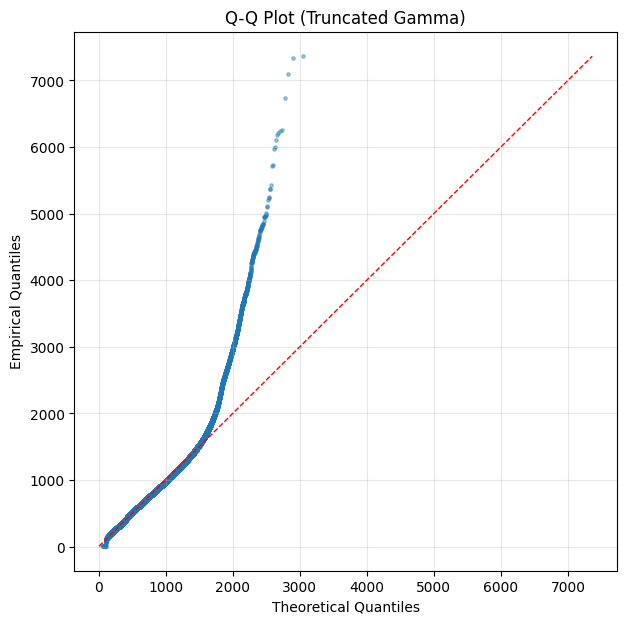

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize, special
import warnings

# Ensure filtered data (<= 8000) is available
U = 8000.0
try:
    filtered_length_data
except NameError:
    try:
        length_data
    except NameError:
        import json
        with open("/data2/zzhang/dir1/LLaMA-Factory-Lenght-Value-Model/data/dapo_math_17k_7000.json", "r") as f:
            _data = json.load(f)
        length_data = [d["meta_info"]["answer_token_length"] for d in _data]
    filtered_length_data = [x for x in length_data if x <= U]

x = np.asarray(filtered_length_data, dtype=float)
x = x[np.isfinite(x)]
x = x[(x >= 0) & (x <= U)]
N = len(x)

# Baseline: re-fit non-truncated Gamma (loc=0) on filtered data
shape_nt, loc_nt, scale_nt = stats.gamma.fit(x, floc=0)
F_U_nt = stats.gamma.cdf(U, shape_nt, loc=0, scale=scale_nt)

# Truncated Gamma MLE (loc fixed at 0)
# log-likelihood: sum(log f(x; k,θ)) - N*log F(U; k,θ)

def neg_loglike(log_k, log_theta):
    k = float(np.exp(log_k))
    theta = float(np.exp(log_theta))
    F_U = stats.gamma.cdf(U, k, loc=0, scale=theta)
    if F_U <= 0.0:
        return np.inf
    ll = np.sum(stats.gamma.logpdf(x, k, loc=0, scale=theta)) - N * np.log(F_U)
    return -ll

init = np.log([shape_nt, scale_nt])
res = optimize.minimize(lambda v: neg_loglike(v[0], v[1]), init, method='L-BFGS-B')
if not res.success:
    warnings.warn(f"Truncated Gamma fit did not fully converge: {res.message}")
shape_t, scale_t = np.exp(res.x[0]), np.exp(res.x[1])
F_U_t = stats.gamma.cdf(U, shape_t, loc=0, scale=scale_t)

# Truncated moments using incomplete gamma
# E[X 1_{X<=U}] = θ k * gammainc(k+1, U/θ)
# E[X^2 1_{X<=U}] = θ^2 k (k+1) * gammainc(k+2, U/θ)
# Mean_trunc = E[X 1_{X<=U}] / F(U); Var_trunc = E[X^2 1_{X<=U}]/F(U) - Mean_trunc^2
z_t = U / scale_t
EX1 = scale_t * shape_t * special.gammainc(shape_t + 1.0, z_t)
EX2 = (scale_t ** 2) * shape_t * (shape_t + 1.0) * special.gammainc(shape_t + 2.0, z_t)
mean_trunc = EX1 / F_U_t
var_trunc = EX2 / F_U_t - mean_trunc ** 2
std_trunc = float(np.sqrt(max(var_trunc, 0.0)))

# Goodness-of-fit tests
# Truncated CDF: F_T(x) = F(x)/F(U)
F_trunc = lambda v: stats.gamma.cdf(v, shape_t, loc=0, scale=scale_t) / F_U_t
ks_stat_t, ks_p_t = stats.kstest(x, F_trunc)
# Cramer-von Mises (one-sample) against truncated CDF
cvm_res = stats.cramervonmises(x, F_trunc)

print("Truncated Gamma (loc=0) fit for X<=8000")
print(f"  shape={shape_t:.4f}, scale={scale_t:.4f}")
print(f"  KS: statistic={ks_stat_t:.4f}, p-value={ks_p_t:.4f}")
print(f"  CvM: statistic={cvm_res.statistic:.4f}, p-value={getattr(cvm_res, 'pvalue', np.nan):.4f}")
print("  Moments (theoretical, truncated):")
print(f"    mean={mean_trunc:.2f}, std={std_trunc:.2f}")
print("  Moments (empirical):")
print(f"    mean={np.mean(x):.2f}, std={np.std(x):.2f}")

# Visualization: histogram + PDFs
x_grid = np.linspace(0.0, min(U, float(np.max(x))), 1000)
pdf_nt = stats.gamma.pdf(x_grid, shape_nt, loc=0, scale=scale_nt)
pdf_t = stats.gamma.pdf(x_grid, shape_t, loc=0, scale=scale_t) / F_U_t

plt.figure(figsize=(10, 6))
plt.hist(x, bins=100, density=True, alpha=0.5, edgecolor='black', label='Data (<=8000)')
plt.plot(x_grid, pdf_nt, 'C1-', lw=2, label='Gamma (non-trunc)')
plt.plot(x_grid, pdf_t, 'C3-', lw=2, label='Gamma (truncated)')
plt.title('Histogram with Non-truncated vs Truncated Gamma PDFs')
plt.xlabel('Length (tokens)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ECDF vs truncated CDF
sorted_x = np.sort(x)
ecdf = np.arange(1, N + 1) / N
cdf_t_vals = F_trunc(sorted_x)

plt.figure(figsize=(10, 5))
plt.plot(sorted_x, ecdf, label='Empirical CDF', alpha=0.8)
plt.plot(sorted_x, cdf_t_vals, label='Truncated Gamma CDF', alpha=0.8)
plt.axvline(U, color='k', linestyle='--', alpha=0.4, label='U=8000')
plt.title('ECDF vs Truncated Gamma CDF')
plt.xlabel('Length (tokens)')
plt.ylabel('CDF')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Q-Q plot for truncated Gamma
q = (np.arange(1, N + 1) - 0.5) / N
q = np.clip(q, 1e-8, 1 - 1e-8)
# Truncated quantile: F^{-1}(q * F(U))
th_q = stats.gamma.ppf(q * F_U_t, shape_t, loc=0, scale=scale_t)

plt.figure(figsize=(7, 7))
plt.scatter(th_q, sorted_x, s=6, alpha=0.4)
min_ax = min(float(np.min(th_q)), float(np.min(sorted_x)))
max_ax = max(float(np.max(th_q)), float(np.max(sorted_x)))
plt.plot([min_ax, max_ax], [min_ax, max_ax], 'r--', lw=1)
plt.title('Q-Q Plot (Truncated Gamma)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Empirical Quantiles')
plt.grid(True, alpha=0.3)
plt.show()


Truncated model comparison (sorted by BIC):
- GenGamma (trunc, loc=0): BIC=6323825.21, AIC=6323792.18, KS=0.0199, CvM=68.21, logL=-3161893.1
- Lognormal (trunc, loc=0): BIC=6327156.01, AIC=6327133.98, KS=0.0297, CvM=134.22, logL=-3163565.0
- Gamma (trunc, loc=0): BIC=6329477.05, AIC=6329455.02, KS=0.0222, CvM=68.40, logL=-3164725.5
- Weibull_min (trunc, loc=0): BIC=6407509.72, AIC=6407487.69, KS=0.0674, CvM=928.62, logL=-3203741.8

Best by BIC: GenGamma (trunc, loc=0)
Params: (37.115764023651494, 0.4276919594694616, 0.0, 0.1610102356055413)


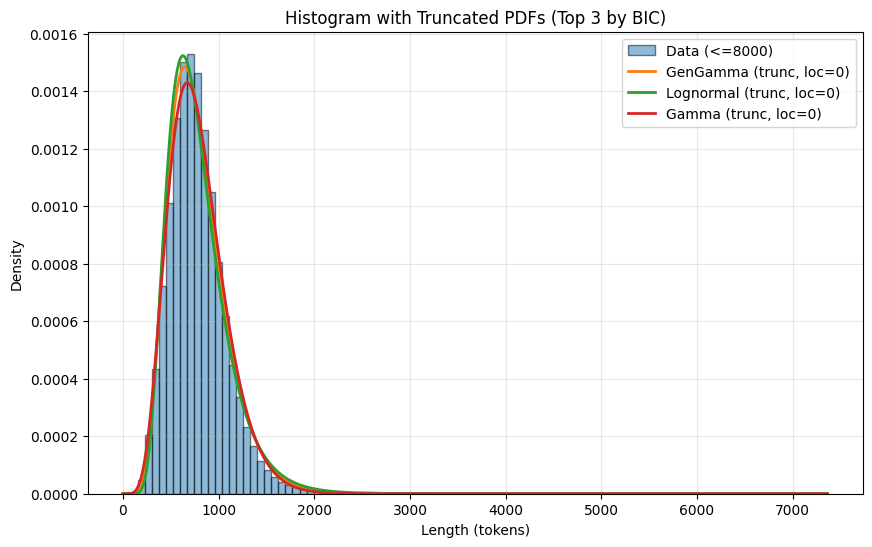

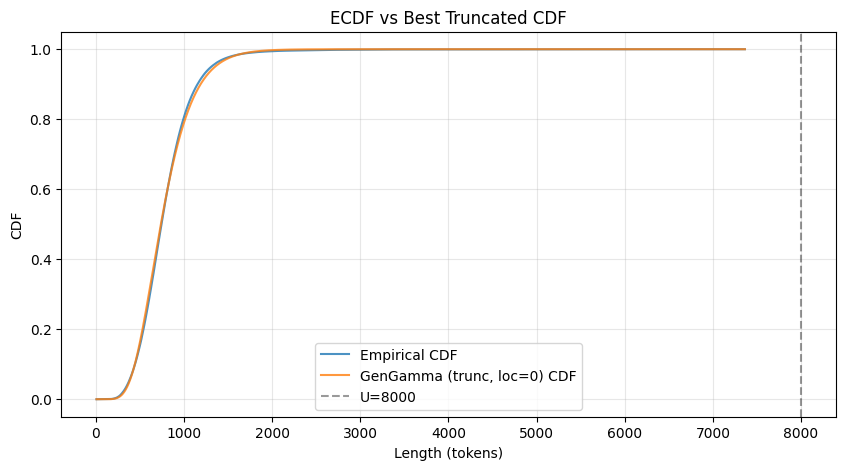

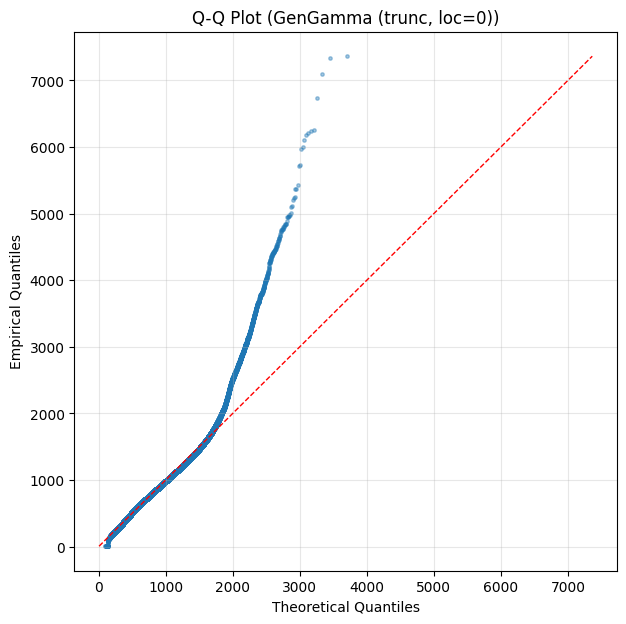

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize
import warnings

# Use filtered data x (<= U) from previous cell if available
U = 8000.0
try:
    x  # from previous truncated fit cell
except NameError:
    try:
        filtered_length_data
    except NameError:
        import json
        with open("/data2/zzhang/dir1/LLaMA-Factory-Lenght-Value-Model/data/dapo_math_17k_7000.json", "r") as f:
            _data = json.load(f)
        length_data = [d["meta_info"]["answer_token_length"] for d in _data]
        filtered_length_data = [v for v in length_data if v <= U]
    x = np.asarray(filtered_length_data, dtype=float)
    x = x[np.isfinite(x)]
    x = x[(x >= 0) & (x <= U)]

N = len(x)

# Helper for truncated MLE with positive parameters using log-reparameterization
class TruncFit:
    def __init__(self, name, dist, param_kind):
        self.name = name
        self.dist = dist
        self.param_kind = param_kind  # tuple of names controlling param mapping

    def _param_from_vec(self, v):
        # Map optimizer vector to scipy params (shape(s), loc, scale) with loc fixed 0
        if self.param_kind == ("gamma",):
            k = float(np.exp(v[0])); theta = float(np.exp(v[1]))
            return (k, 0.0, theta), 2
        if self.param_kind == ("lognorm",):
            s = float(np.exp(v[0])); scale = float(np.exp(v[1]))
            return (s, 0.0, scale), 2
        if self.param_kind == ("weibull_min",):
            c = float(np.exp(v[0])); scale = float(np.exp(v[1]))
            return (c, 0.0, scale), 2
        if self.param_kind == ("gengamma",):
            a = float(np.exp(v[0])); c = float(np.exp(v[1])); scale = float(np.exp(v[2]))
            return (a, c, 0.0, scale), 3
        raise ValueError("Unknown param kind")

    def nll(self, v):
        params, _k = self._param_from_vec(v)
        try:
            F_U = self.dist.cdf(U, *params)
            if not np.isfinite(F_U) or F_U <= 0.0:
                return np.inf
            lp = self.dist.logpdf(x, *params)
            lp = np.where(np.isfinite(lp), lp, -1e12)
            ll = float(np.sum(lp) - N * np.log(F_U))
            return -ll
        except Exception:
            return np.inf

    def fit(self, init):
        res = optimize.minimize(self.nll, init, method="L-BFGS-B")
        params, k = self._param_from_vec(res.x)
        # Compute stats
        F_U = self.dist.cdf(U, *params)
        with np.errstate(divide='ignore', invalid='ignore', over='ignore'):
            ll_vals = self.dist.logpdf(x, *params)
        ll_vals = np.where(np.isfinite(ll_vals), ll_vals, -1e12)
        ll = float(np.sum(ll_vals) - N * np.log(F_U))
        aic = 2 * k - 2 * ll
        bic = k * np.log(N) - 2 * ll
        # KS/CvM against truncated CDF
        F_trunc = lambda v: self.dist.cdf(v, *params) / F_U
        ks_stat, ks_p = stats.kstest(x, F_trunc)
        cvm_res = stats.cramervonmises(x, F_trunc)
        return {
            'name': self.name,
            'params': params,
            'k': k,
            'success': bool(getattr(res, 'success', False)),
            'message': getattr(res, 'message', ''),
            'AIC': aic,
            'BIC': bic,
            'logL': ll,
            'KS_stat': ks_stat,
            'KS_p': ks_p,
            'CvM_stat': float(cvm_res.statistic),
            'CvM_p': float(getattr(cvm_res, 'pvalue', np.nan)),
            'F_U': float(F_U),
        }

fits = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Initializations from non-truncated fits on x
    k_g, _, th_g = stats.gamma.fit(x, floc=0)
    s_l, _, sc_l = stats.lognorm.fit(x, floc=0)
    c_w, _, sc_w = stats.weibull_min.fit(x, floc=0)
    a_ge, c_ge, _, sc_ge = stats.gengamma.fit(x, floc=0)

    models = [
        (TruncFit('Gamma (trunc, loc=0)', stats.gamma, ("gamma",)), np.log([k_g, th_g])),
        (TruncFit('Lognormal (trunc, loc=0)', stats.lognorm, ("lognorm",)), np.log([s_l, sc_l])),
        (TruncFit('Weibull_min (trunc, loc=0)', stats.weibull_min, ("weibull_min",)), np.log([c_w, sc_w])),
        (TruncFit('GenGamma (trunc, loc=0)', stats.gengamma, ("gengamma",)), np.log([a_ge, c_ge, sc_ge])),
    ]

    for m, init in models:
        try:
            fits.append(m.fit(init))
        except Exception as e:
            print(f"Fit failed for {m.name}: {e}")

if not fits:
    raise RuntimeError("No truncated fits succeeded.")

fits_sorted = sorted(fits, key=lambda d: d['BIC'])
print("Truncated model comparison (sorted by BIC):")
for f in fits_sorted:
    print(f"- {f['name']}: BIC={f['BIC']:.2f}, AIC={f['AIC']:.2f}, KS={f['KS_stat']:.4f}, CvM={f['CvM_stat']:.2f}, logL={f['logL']:.1f}")

best = fits_sorted[0]
print(f"\nBest by BIC: {best['name']}")
print(f"Params: {best['params']}")

# Plot histogram with top PDFs (truncated)
plt.figure(figsize=(10, 6))
plt.hist(x, bins=100, density=True, alpha=0.5, edgecolor='black', label='Data (<=8000)')
xx = np.linspace(0.0, float(np.max(x)), 1000)
for f in fits_sorted[:3]:
    dist = {'Gamma (trunc, loc=0)': stats.gamma,
            'Lognormal (trunc, loc=0)': stats.lognorm,
            'Weibull_min (trunc, loc=0)': stats.weibull_min,
            'GenGamma (trunc, loc=0)': stats.gengamma}[f['name']]
    F_U = f['F_U']
    pdf = dist.pdf(xx, *f['params']) / F_U
    plt.plot(xx, pdf, lw=2, label=f["name"])
plt.title('Histogram with Truncated PDFs (Top 3 by BIC)')
plt.xlabel('Length (tokens)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ECDF vs best truncated CDF
sorted_x = np.sort(x)
ecdf = np.arange(1, N + 1) / N
best_dist = {'Gamma (trunc, loc=0)': stats.gamma,
             'Lognormal (trunc, loc=0)': stats.lognorm,
             'Weibull_min (trunc, loc=0)': stats.weibull_min,
             'GenGamma (trunc, loc=0)': stats.gengamma}[best['name']]
F_U_best = best['F_U']
F_best = lambda v: best_dist.cdf(v, *best['params']) / F_U_best

plt.figure(figsize=(10, 5))
plt.plot(sorted_x, ecdf, label='Empirical CDF', alpha=0.8)
plt.plot(sorted_x, F_best(sorted_x), label=f"{best['name']} CDF", alpha=0.8)
plt.axvline(U, color='k', linestyle='--', alpha=0.4, label='U=8000')
plt.title('ECDF vs Best Truncated CDF')
plt.xlabel('Length (tokens)')
plt.ylabel('CDF')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Q-Q for best truncated model
q = (np.arange(1, N + 1) - 0.5) / N
q = np.clip(q, 1e-8, 1 - 1e-8)
th_q = best_dist.ppf(q * F_U_best, *best['params'])

plt.figure(figsize=(7, 7))
plt.scatter(th_q, sorted_x, s=6, alpha=0.4)
mn = min(float(np.min(th_q)), float(np.min(sorted_x)))
mx = max(float(np.max(th_q)), float(np.max(sorted_x)))
plt.plot([mn, mx], [mn, mx], 'r--', lw=1)
plt.title(f"Q-Q Plot ({best['name']})")
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Empirical Quantiles')
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
len(data)